In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import (precision_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler 

import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_ROOT = Path('./Data Explorer/')
MODELS_PATH = Path('./models/')

TRAIN_PATH = DATA_ROOT / 'train.csv'
TEST_PATH = DATA_ROOT / 'test.csv'
SUBMIT_PATH = DATA_ROOT / 'gender_submission.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

## 2. Загрузка данных в Data Frame
#### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные
- gender_submission.csv - образец файла для отправки в правильном формате
#### Описание признаков данных
- survival: выживший -1 или -0
- pclass: Класс билетов 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Пол
- Age: Возраст в годах
- sibsp: братьев и сестер/супругов на борту "Титаника"
- parch: родителей/детей на борту "Титаника"
- ticket: Номер билета
- fare: Пассажирский тариф
- cabin: Номер каюты
- embarked: Порт отправления C = Шербур, Q = Квинстаун, S = Саутгемптон


In [3]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
class DataPreprocessing():
    def __init__(self):
        self.medians = None
        self.mode =  None
        self.scaler = RobustScaler()

    def fit(self, df):
        df = df.copy()
        #заполняем переменные класса
        self.medians = df.median()
        self.mode = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].mode()

    def transform(self, df):
        df = df.copy()
        #используем метод replace() для замены 1 на 3 и 3 на 1 в столбце 'Pclass'
        df = df.replace({'Pclass':{1:3, 3:1}})
        #используем метод replace() для замены male на 1 и female на 2 в столбце 'Sex'
        df = df.replace({'Sex':{'male':1, 'female':2}})
        # Округляем значения к целому 'Age'
        df['Age'] = np.round_(df['Age'], decimals = 0)
        # Исправим пропуски 'Age'(прировняем их к медиане). 
        df.loc[df['Age'].isnull(), 'Age'] = self.medians[3]
        #используем метод replace() для замены в столбце 'SibSp'
        df = df.replace({'SibSp':{0:8, 1:7, 2:6, 3:5, 5:3, 6:2, 7:1, 8:0}})
        #используем метод replace() для замены в столбце 'Parch'
        df = df.replace({'Parch':{0:6, 1:5, 2:4, 4:2, 5:1, 6:0}})
        # Округляем значения к целому 'Fare'
        df['Fare'] = np.round_(df['Fare'], decimals = 0)
        # удаляем лишнее
        df.drop(['PassengerId','Name','Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
        return df
    
    def fit_scale_merge(self, df):
        #Масштабирование
        df = pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns)
        return df

    def scale_merge(self, df):
        #Масштабирование
        df = pd.DataFrame(self.scaler.transform(df), columns=df.columns)
        return df

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
    plot_confusion_matrix(model, X_train, y_train, cmap=plt.cm.Blues)
    plot_precision_recall_curve(model, X_train, y_train)
    plot_roc_curve(model, X_train, y_train)
    print('\n\nTEST\n\n' + classification_report(y_test, y_test_pred))
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    plot_precision_recall_curve(model, X_test, y_test)
    plot_roc_curve(model, X_test, y_test)

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Обработка данных

In [10]:
df_train = pd.read_csv(TRAIN_PATH, sep=',')
test_df = pd.read_csv(TEST_PATH, sep=',')
sumbit_df = pd.read_csv(SUBMIT_PATH, sep=',')

preprocessor = DataPreprocessing()

y = df_train['Survived']
X = df_train.drop(columns=['Survived'])
preprocessor.fit(X)


X = preprocessor.transform(X)
test = preprocessor.transform(test_df)

X = preprocessor.fit_scale_merge(X)
test = preprocessor.scale_merge(test)

### *Разбиение на train и test*

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

In [12]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.02 MB
Decreased by 42.9%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 42.9%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 49.7%


### Балансировка целевой переменной

In [13]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

1.606694560669456

### Выбор лучшей модели и подбор гиперпараметров

In [14]:
CAT_FEATURE_NAMES = ['Pclass', 'Sex', 'SibSp', 'Parch']
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       384
           1       0.80      0.84      0.82       239

    accuracy                           0.86       623
   macro avg       0.85      0.85      0.85       623
weighted avg       0.86      0.86      0.86       623



TEST

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       165
           1       0.77      0.80      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268

Wall time: 1.17 s


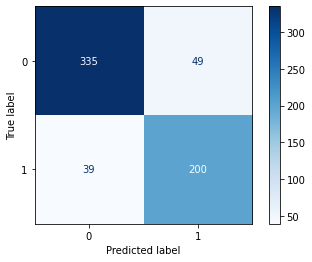

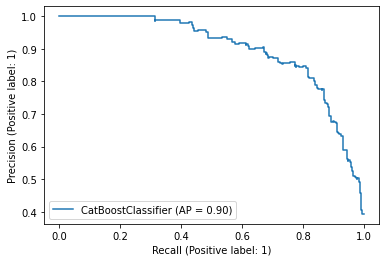

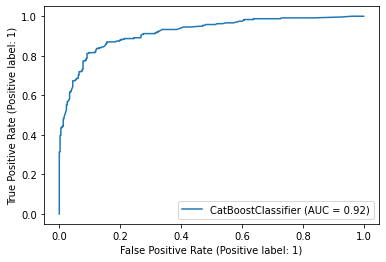

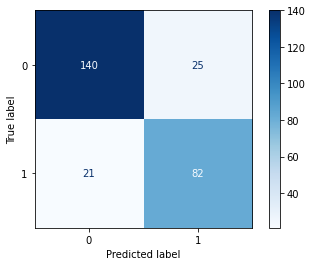

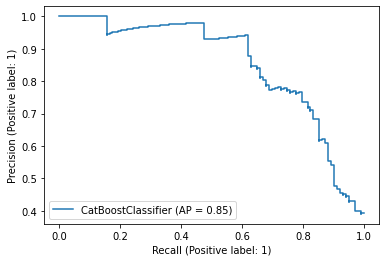

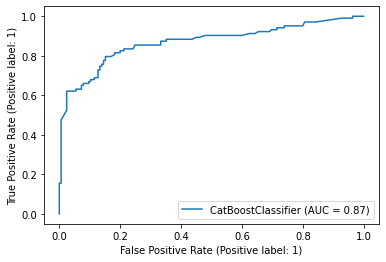

In [15]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

In [16]:
params = {'reg_lambda': np.linspace(0.5, 2, 250)}

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

grid_search = model.randomized_search(params, X_train, y_train, n_iter=20, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.734494108
bestIteration = 0

0:	loss: 0.7344941	best: 0.7344941 (0)	total: 69.7ms	remaining: 1.32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7547911556
bestIteration = 7

1:	loss: 0.7547912	best: 0.7547912 (1)	total: 154ms	remaining: 1.38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.734494108
bestIteration = 0

2:	loss: 0.7344941	best: 0.7547912 (1)	total: 239ms	remaining: 1.35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7844306427
bestIteration = 64

3:	loss: 0.7844306	best: 0.7844306 (3)	total: 550ms	remaining: 2.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.734494108
bestIteration = 0

4:	loss: 0.7344941	best: 0.7844306 (3)	total: 630ms	remaining: 1.89s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7632460682
bestIteration = 30

5:	loss: 0.7632461	best: 0.7844306 (3)	total: 973ms	remaining: 2.27s

In [17]:
grid_search['params']

{'l2_leaf_reg': 1.891566265060241}

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       384
           1       0.85      0.87      0.86       239

    accuracy                           0.89       623
   macro avg       0.89      0.89      0.89       623
weighted avg       0.89      0.89      0.89       623



TEST

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       165
           1       0.74      0.78      0.76       103

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

Wall time: 538 ms


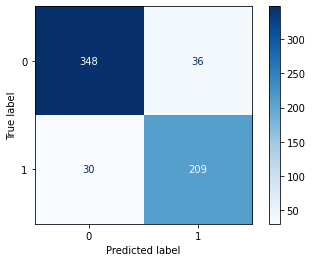

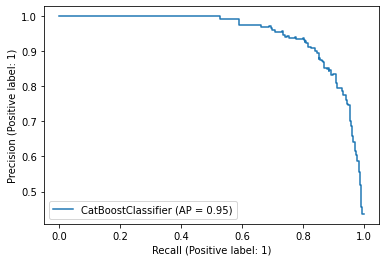

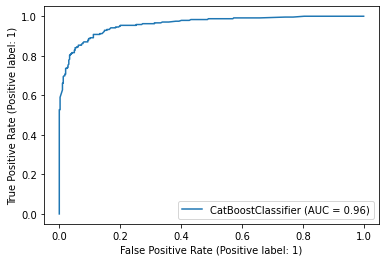

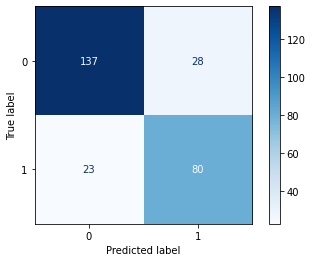

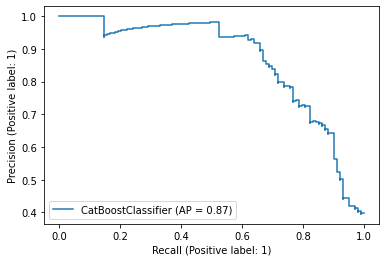

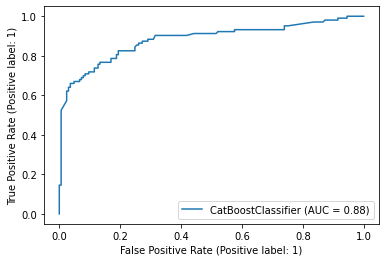

In [18]:
%%time

evaluate_preds(model, X_train, X_valid, y_train, y_valid)

### Подбор оптимального размера выборки, кривая обучения

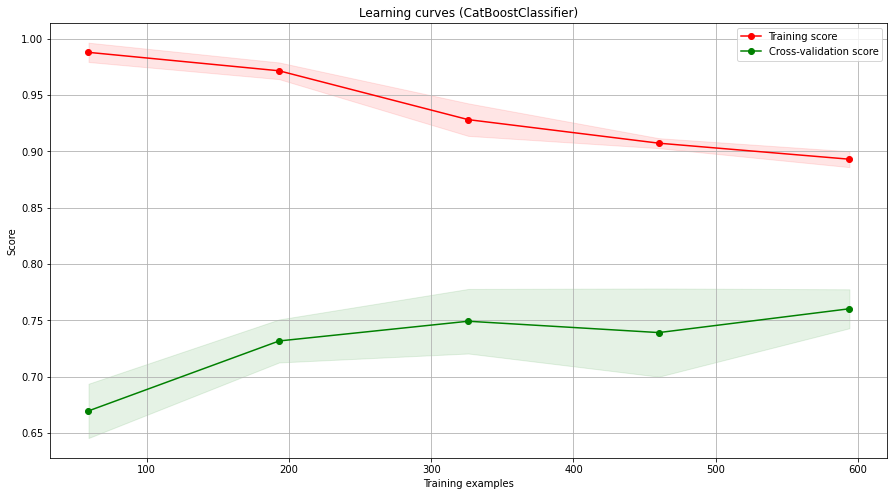

Wall time: 12.9 s


In [19]:
%%time
show_learning_curve_plot(model, X, y)

### Выбор порога вероятности для определения класса

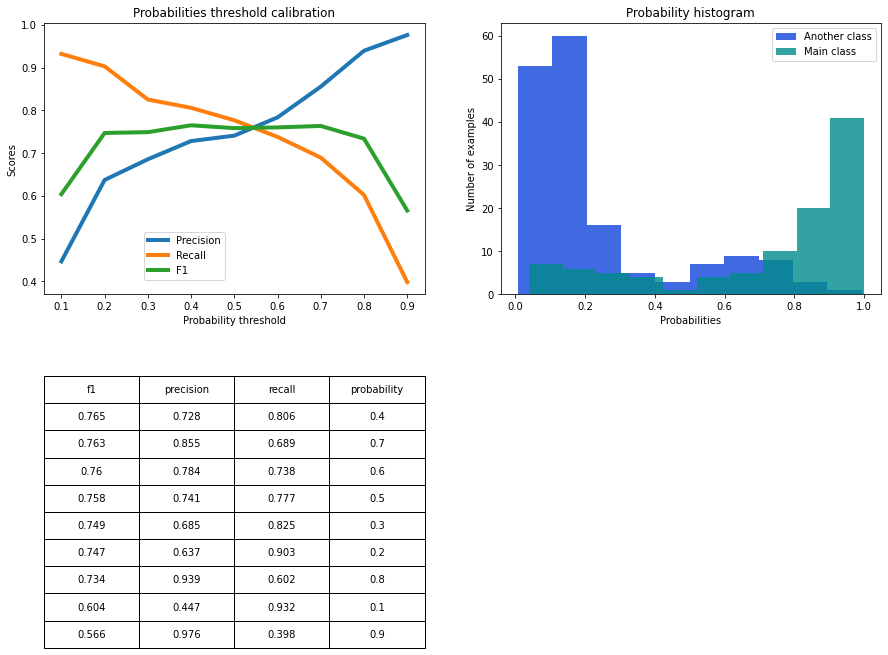

In [28]:
y_test_pred_probs = model.predict_proba(X_valid)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_valid)

### Важность признаков<a class="anchor" id="feature_importances"></a>

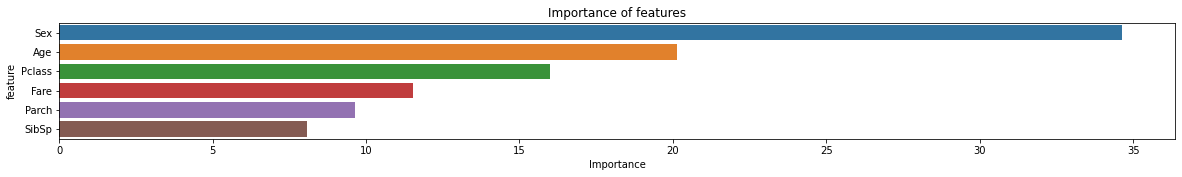

In [21]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       384
           1       0.81      0.83      0.82       239

    accuracy                           0.86       623
   macro avg       0.85      0.85      0.85       623
weighted avg       0.86      0.86      0.86       623



TEST

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       165
           1       0.78      0.79      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268

Wall time: 631 ms


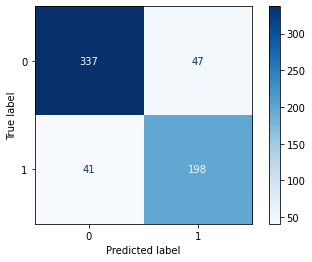

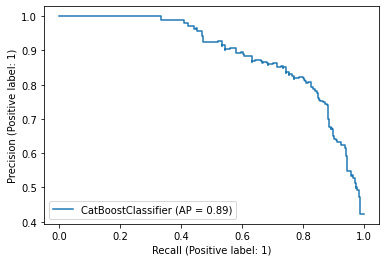

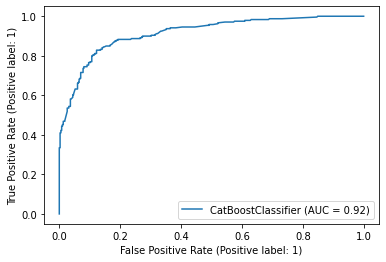

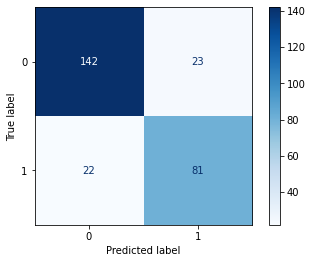

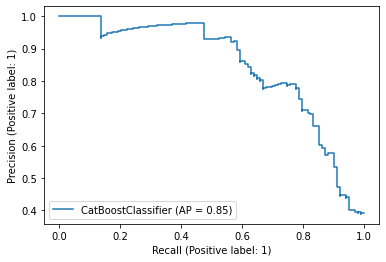

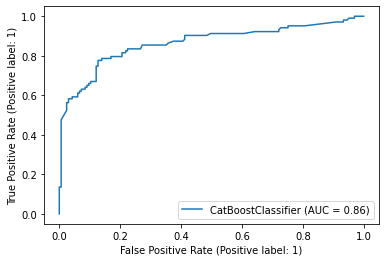

In [22]:
%%time

frozen_params = {
     'class_weights': [1, disbalance], 
     'silent': True,
     'random_state': 21,
     'eval_metric': 'F1',
     'early_stopping_rounds': 20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=7,
                                      reg_lambda=1.89
                                      )

final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

evaluate_preds(final_model, X_train, X_valid, y_train, y_valid)

In [23]:
y_test_pred_probs = final_model.predict_proba(X_valid)
pred_test = np.where(y_test_pred_probs[:, 1] >= 0.6, 1, 0)
print(classification_report(y_valid, pred_test))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       165
           1       0.84      0.63      0.72       103

    accuracy                           0.81       268
   macro avg       0.82      0.78      0.79       268
weighted avg       0.82      0.81      0.81       268



### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [24]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Финальная модель

In [25]:
y_test_pred = final_model.predict_proba(test)
y_test_pred = np.where(y_test_pred[:, 1] >= 0.6, 1, 0)

### Сохранение результата

In [26]:
sumbit_df['Survived'] = y_test_pred
sumbit_df.to_csv('SergeyLazarevich_predictions.csv', index=False)